# Acute Lymphoblastic Leukemia (ALL) Diagnosis Using Neural Networks

[A Guide to Leukemia](https://www.healthline.com/health/leukemia)

[Survival Rates and Outlook for Acute Lymphocytic Leukemia (ALL)](https://www.healthline.com/health/acute-lymphocytic-leukemia-survival-rate-outlook)

![Spirits UP](data/happy_young_girl_with_cancer-1200x628-facebook-1200x628.jpeg)

## Business Understanding:

>Cancer is the second leading cause of death in children aged 5 to 14, and leukemia is the most prevalent cancer in children. Survival rate is directly correlated with how early it is caught. If we can catch the leukemia early enough, we can save the lives of many children. I seek to create a diagnosing method to accurately diagnose leukemia by taking pictures of white blood cells and predicting if they are normal or leukemia cells. Accurately diagnosing leukemia cells early on can save many lives. A Machine Learning model that can accurately identify leukemia cells will enhance the medical profession’s ability to diagnosis at an early stage. Humans are prone to error so a model that can accurately predict will cut down on that human error.


## Data Understanding

Leukemia manifests itself in immature white blood cells called blasts. My data will be images of white blood cells that have been analyzed under a microscope and labeled as normal or cancerous.

The dataset I will be using comes from the [Cancer Imaging Archive](https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=52758223)

In [11]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
import pandas as pd
import numpy as np
import csv
import os
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import StandardScaler, LabelBinarizer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_predict
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras import optimizers
from keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
print ("Tensorflow version:", tf.__version__)
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop
from tensorflow.keras.metrics import binary_crossentropy, categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight 
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
import time
import scipy
from scipy import ndimage
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from IPython.core.display import display, HTML
# stop annoying tensorflow warning messages
import logging
import splitfolders
logging.getLogger("tensorflow").setLevel(logging.ERROR)
np.random.seed(123)
print ('modules loaded')

Tensorflow version: 2.8.0
modules loaded


## *Data Pre-Processing*

#### The Data for this project can be downloaded [here](https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=52758223)

### The data for this project was acquired in three parts:

> #### 1) A training set separated into 3 directories, each with separate class labeled directories
> #### 2) A validation set with all images in the same directory and a CSV file with filenames and class labels
> #### 3) A test set with no class labels

- #### We will combine all the data of the training and validation sets into labeled directories and split the whole into training, validation, and test sets for use in this project.

- #### We will re-name the provided test set and to "unlabeled" and reserve it for demonstration purposes, as there is no way of knowing if the predicitions are correct and how a partivular model is performing with it.

### Training Data:

In [2]:
# Set paths of 3x2 pre-labeled directories
f0_data_training_ALL_dir = 'data/PKG - C-NMC_Leukemia/C-NMC_Leukemia/C-NMC_training_data/fold_0/all/'
f0_data_training_Normal_dir = 'data/PKG - C-NMC_Leukemia/C-NMC_Leukemia/C-NMC_training_data/fold_0/hem/'

f1_data_training_ALL_dir = 'data/PKG - C-NMC_Leukemia/C-NMC_Leukemia/C-NMC_training_data/fold_1/all/'
f1_data_training_Normal_dir = 'data/PKG - C-NMC_Leukemia/C-NMC_Leukemia/C-NMC_training_data/fold_1/hem/'

f2_data_training_ALL_dir = 'data/PKG - C-NMC_Leukemia/C-NMC_Leukemia/C-NMC_training_data/fold_2/all/'
f2_data_training_Normal_dir = 'data/PKG - C-NMC_Leukemia/C-NMC_Leukemia/C-NMC_training_data/fold_2/hem/'

# Create lists of all ALL images in these directories
f0_imgs_ALL = [file for file in os.listdir(f0_data_training_ALL_dir) if file.endswith('.bmp')]
f1_imgs_ALL = [file for file in os.listdir(f1_data_training_ALL_dir) if file.endswith('.bmp')]
f2_imgs_ALL = [file for file in os.listdir(f2_data_training_ALL_dir) if file.endswith('.bmp')]

# Create lists of all Normal images in these directories
f0_imgs_Normal = [file for file in os.listdir(f0_data_training_Normal_dir) if file.endswith('.bmp')]
f1_imgs_Normal = [file for file in os.listdir(f1_data_training_Normal_dir) if file.endswith('.bmp')]
f2_imgs_Normal = [file for file in os.listdir(f2_data_training_Normal_dir) if file.endswith('.bmp')]


### Validation Data

In [3]:
# Set paths of directory
data_val_dir = 'data/PKG - C-NMC_Leukemia/C-NMC_Leukemia/C-NMC_test_prelim_phase_data/'

# Read in and inspect the dataframe with the filenames and labels
val_df = pd.read_csv('data/PKG - C-NMC_Leukemia/C-NMC_Leukemia/C-NMC_test_prelim_phase_data/C-NMC_test_prelim_phase_data_labels.csv')

val_df.head()

,Patient_ID,new_names,labels
0,UID_57_29_1_all.bmp,1.bmp,1
1,UID_57_22_2_all.bmp,2.bmp,1
2,UID_57_31_3_all.bmp,3.bmp,1
3,UID_H49_35_1_hem.bmp,4.bmp,0
4,UID_58_6_13_all.bmp,5.bmp,1


In [4]:
# Change labels to use "binary" class_mode
val_df = val_df.replace({'labels':{0 : 'ALL', 1 : 'Normal'}})

# filenames do not use 'Patient_ID', so drop the column
val_df = val_df.drop('Patient_ID', axis=1)

val_df.head()

,new_names,labels
0,1.bmp,Normal
1,2.bmp,Normal
2,3.bmp,Normal
3,4.bmp,ALL
4,5.bmp,Normal


In [5]:
# Group the the df by labels so we can split them
val_split_df = val_df.groupby('labels')

# Split the filenames into separate df's and create lists of them
val_ALL_df = val_split_df.get_group('ALL')
val_images_ALL = [img for img in val_ALL_df.new_names]

val_Normal_df = val_split_df.get_group('Normal')
val_images_Normal = [img for img in val_Normal_df.new_names]

In [6]:
val_ALL_df.head()

,new_names,labels
3,4.bmp,ALL
6,7.bmp,ALL
7,8.bmp,ALL
12,13.bmp,ALL
13,14.bmp,ALL


In [7]:
val_images_ALL[:5]

['4.bmp', '7.bmp', '8.bmp', '13.bmp', '14.bmp']

In [8]:
val_Normal_df.head()

,new_names,labels
0,1.bmp,Normal
1,2.bmp,Normal
2,3.bmp,Normal
4,5.bmp,Normal
5,6.bmp,Normal


In [9]:
val_images_Normal[:5]

['1.bmp', '2.bmp', '3.bmp', '5.bmp', '6.bmp']

### Combine the data into one directory

In [10]:
# Set new directory path for all images to be combined
new_dir = 'data/labeled_images/'
combo_ALL_dir = os.path.join(new_dir, 'ALL')
combo_Normal_dir = os.path.join(new_dir, 'Normal')

# Create the new directory
os.mkdir(new_dir)
os.mkdir(combo_ALL_dir)
os.mkdir(combo_Normal_dir)

In [11]:
#  Move images from training_data directories:

# ALL
for img in f0_imgs_ALL:
    origin = os.path.join(f0_data_training_ALL_dir, img)
    destination = os.path.join(combo_ALL_dir, img)
    os.rename(origin, destination)
    
for img in f1_imgs_ALL:
    origin = os.path.join(f1_data_training_ALL_dir, img)
    destination = os.path.join(combo_ALL_dir, img)
    os.rename(origin, destination)
    
for img in f2_imgs_ALL:
    origin = os.path.join(f2_data_training_ALL_dir, img)
    destination = os.path.join(combo_ALL_dir, img)
    os.rename(origin, destination)
    
# Normal
for img in f0_imgs_Normal:
    origin = os.path.join(f0_data_training_Normal_dir, img)
    destination = os.path.join(combo_Normal_dir, img)
    os.rename(origin, destination)
    
for img in f1_imgs_Normal:
    origin = os.path.join(f1_data_training_Normal_dir, img)
    destination = os.path.join(combo_Normal_dir, img)
    os.rename(origin, destination)
    
for img in f2_imgs_Normal:
    origin = os.path.join(f2_data_training_Normal_dir, img)
    destination = os.path.join(combo_Normal_dir, img)
    os.rename(origin, destination)

In [12]:
#  Move images from validation_data directory:

# ALL
for img in val_images_ALL:
    origin = os.path.join(data_val_dir, img)
    destination = os.path.join(combo_ALL_dir, img)
    os.rename(origin, destination)

# Normal
for img in val_images_Normal:
    origin = os.path.join(data_val_dir, img)
    destination = os.path.join(combo_Normal_dir, img)
    os.rename(origin, destination)


In [13]:
total = len(os.listdir(combo_ALL_dir)) + len(os.listdir(combo_Normal_dir))
print('There are', len(os.listdir(combo_ALL_dir)) + len(os.listdir(combo_Normal_dir)), 'total images')
print("--------------------------------")
print('There are', len(os.listdir(combo_ALL_dir)), 'ALL cell images')
print('There are', len(os.listdir(combo_Normal_dir)), 'Normal cell images')


There are 12528 total images
--------------------------------
There are 7920 ALL cell images
There are 4608 Normal cell images


### Split the data into training, validation, and test sets
>### Training   ~ 80%
>### Validation ~ 19%
>### Test       ~ 1%

In [14]:
# Create new directory for the training, validation, and testing datasets
tvt_dir = 'data/tvt/'
os.mkdir(tvt_dir)

# Create paths for new dirctory datasets and class label folders
train_folder = os.path.join(tvt_dir, 'train')
train_ALL = os.path.join(train_folder, 'ALL')
train_Normal = os.path.join(train_folder, 'Normal')

val_folder = os.path.join(tvt_dir, 'validation')
val_ALL = os.path.join(val_folder, 'ALL')
val_Normal = os.path.join(val_folder, 'Normal')

test_folder = os.path.join(tvt_dir, 'test')
test_ALL = os.path.join(test_folder, 'ALL')
test_Normal = os.path.join(test_folder, 'Normal')

# Create the class label folders
os.mkdir(train_folder)
os.mkdir(train_ALL)
os.mkdir(train_Normal)

os.mkdir(val_folder)
os.mkdir(val_ALL)
os.mkdir(val_Normal)

os.mkdir(test_folder)
os.mkdir(test_ALL)
os.mkdir(test_Normal)

In [15]:
# do the math for our splits
print('There are', len(os.listdir(combo_ALL_dir)) + len(os.listdir(combo_Normal_dir)), 'total images')
print("--------------------------------")
print('There are', len(os.listdir(combo_ALL_dir)), 'ALL cell images')
print('There are', len(os.listdir(combo_Normal_dir)), 'Normal cell images')

train_ALL_total = (len(os.listdir(combo_ALL_dir))) * 0.80
train_Normal_total = (len(os.listdir(combo_Normal_dir))) * 0.80

val_ALL_total = (len(os.listdir(combo_ALL_dir))) * 0.19
val_Normal_total = (len(os.listdir(combo_Normal_dir))) * 0.19
               
test_ALL_total = (len(os.listdir(combo_ALL_dir))) * 0.01
test_Normal_total = (len(os.listdir(combo_Normal_dir))) * 0.01
print("--------------------------------")
print("--------------------------------")
print("Train ALL        :", round(train_ALL_total,2), "  :", )
print("Train Normal     :", round(train_Normal_total,2), "  :", )
print("--------------------------------")
print("Validation ALL   :", round(val_ALL_total,2),   "  :", val_ALL_total+train_ALL_total)
print("Validation Nomral:", round(val_Normal_total,2),   "  :", val_Normal_total+train_Normal_total)
print("--------------------------------")
print("Test ALL         :", round(test_ALL_total,2),  "    :", val_ALL_total+train_ALL_total+test_ALL_total)
print("Test Normal      :", round(test_Normal_total,2),  "   :", val_Normal_total+train_Normal_total+test_Normal_total)

There are 12528 total images
--------------------------------
There are 7920 ALL cell images
There are 4608 Normal cell images
--------------------------------
--------------------------------
Train ALL        : 6336.0   :
Train Normal     : 3686.4   :
--------------------------------
Validation ALL   : 1504.8   : 7840.8
Validation Nomral: 875.52   : 4561.92
--------------------------------
Test ALL         : 79.2     : 7920.0
Test Normal      : 46.08    : 4608.0


### Create the Splits

In [16]:
# Create iterables
imgs_ALL = [img for img in os.listdir(combo_ALL_dir)]
imgs_Normal = [img for img in os.listdir(combo_Normal_dir)]

# train ALL
imgs = imgs_ALL[:6337]
for img in imgs:
    origin = os.path.join(combo_ALL_dir, img)
    destination = os.path.join(train_ALL, img)
    shutil.copyfile(origin, destination)
    
# validation ALL
imgs = imgs_ALL[6337:7841]
for img in imgs:
    origin = os.path.join(combo_ALL_dir, img)
    destination = os.path.join(val_ALL, img)
    shutil.copyfile(origin, destination)

# test ALL
imgs = imgs_ALL[7841:]
for img in imgs:
    origin = os.path.join(combo_ALL_dir, img)
    destination = os.path.join(test_ALL, img)
    shutil.copyfile(origin, destination)
    
# train Normal
imgs = imgs_Normal[:3687]
for img in imgs:
    origin = os.path.join(combo_Normal_dir, img)
    destination = os.path.join(train_Normal, img)
    shutil.copyfile(origin, destination)

# validation Normal
imgs = imgs_Normal[3687:4562]
for img in imgs:
    origin = os.path.join(combo_Normal_dir, img)
    destination = os.path.join(val_Normal, img)
    shutil.copyfile(origin, destination)
    
# test Normal
imgs = imgs_Normal[4562:]
for img in imgs:
    origin = os.path.join(combo_Normal_dir, img)
    destination = os.path.join(test_Normal, img)
    shutil.copyfile(origin, destination)

In [17]:
# Reserve unlabeled data
origin_path =  'data/PKG - C-NMC_Leukemia/C-NMC_Leukemia/C-NMC_test_final_phase_data/'
destination_path = 'data/unlabeled_images/'
os.mkdir(destination_path)

unlabeled_images = [img for img in os.listdir(origin_path)]

# Move unlabeled images to the new directory
for img in unlabeled_images:
    origin = os.path.join(origin_path, img)
    destination = os.path.join(destination_path, img)
    os.rename(origin, destination)

In [18]:
#Remove unnecessary directories from the 'data' file
shutil.rmtree('data/PKG - C-NMC_Leukemia/')

# Build a baseline model

In [19]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        'data/tvt/train',
        classes={'Normal':0, 'ALL':1},
        class_mode='binary',
        batch_size=10024)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        'data/tvt/validation',
        classes={'Normal':0, 'ALL':1},
        class_mode='binary',
        batch_size = 2379)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        'data/tvt/test',
        classes={'Normal':0, 'ALL':1},        
        class_mode='binary',
        batch_size = 125)

Found 10024 images belonging to 2 classes.
Found 2379 images belonging to 2 classes.
Found 125 images belonging to 2 classes.


In [20]:
train_generator.class_indices

{'Normal': 0, 'ALL': 1}

In [21]:
val_generator.class_indices

{'Normal': 0, 'ALL': 1}

In [22]:
test_generator.class_indices

{'Normal': 0, 'ALL': 1}

In [23]:
# create the data sets
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 10024
Number of testing samples: 125
Number of validation samples: 2379
train_images shape: (10024, 256, 256, 3)
train_labels shape: (10024,)
test_images shape: (125, 256, 256, 3)
test_labels shape: (125,)
val_images shape: (2379, 256, 256, 3)
val_labels shape: (2379,)


In [24]:
#  Un-row the image matrices for modeling
train_x = train_images.reshape(train_images.shape[0], -1)
test_x = test_images.reshape(test_images.shape[0], -1)
val_x = val_images.reshape(val_images.shape[0], -1)

print(train_x.shape)
print(test_x.shape)
print(val_x.shape)

(10024, 196608)
(125, 196608)
(2379, 196608)


In [5]:
# The datasets is imbalanced so we will define class_weights to use for training
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes
                                                 )

train_class_weights = dict(enumerate(class_weights))

In [6]:
train_class_weights

{0: 1.3593707621372388, 1: 0.7909105254852454}

In [27]:
# Build the model and add layers
baseline_model = models.Sequential()

baseline_model.add(layers.Dense(16, activation='relu', input_shape=(196608,)))
baseline_model.add(layers.Dense(32, activation='relu'))

# Output layer
baseline_model.add(layers.Dense(1, activation='sigmoid'))

2022-03-02 11:08:33.007767: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
# Compile and fit the model to train
baseline_model.compile(optimizer=Adam(learning_rate=0.0001),
                          loss='binary_crossentropy',
                          metrics=['accuracy'])

baseline_history = baseline_model.fit(train_x,
                                        train_labels,
                                        epochs=150,
                                        batch_size=512,
                                        validation_data=(val_x, val_labels),
                                        class_weight=train_class_weights,)

Epoch 1/150
20/20 [==============================] - 4s 149ms/step - loss: 0.6136 - accuracy: 0.6994 - val_loss: 0.5975 - val_accuracy: 0.6999
Epoch 2/150
20/20 [==============================] - 3s 136ms/step - loss: 0.5912 - accuracy: 0.7178 - val_loss: 0.5925 - val_accuracy: 0.6986
Epoch 3/150
20/20 [==============================] - 3s 135ms/step - loss: 0.5846 - accuracy: 0.7181 - val_loss: 0.5958 - val_accuracy: 0.6936
Epoch 4/150
20/20 [==============================] - 3s 137ms/step - loss: 0.5808 - accuracy: 0.7204 - val_loss: 0.6051 - val_accuracy: 0.6843
Epoch 5/150
20/20 [==============================] - 3s 140ms/step - loss: 0.5754 - accuracy: 0.7261 - val_loss: 0.5897 - val_accuracy: 0.7011
Epoch 6/150
20/20 [==============================] - 3s 138ms/step - loss: 0.5717 - accuracy: 0.7266 - val_loss: 0.5675 - val_accuracy: 0.7243
Epoch 7/150
20/20 [==============================] - 3s 136ms/step - loss: 0.5719 - accuracy: 0.7266 - val_loss: 0.5636 - val_accuracy: 0.7230

Epoch 58/150
20/20 [==============================] - 3s 139ms/step - loss: 0.4083 - accuracy: 0.8284 - val_loss: 0.5651 - val_accuracy: 0.7301
Epoch 59/150
20/20 [==============================] - 3s 137ms/step - loss: 0.4063 - accuracy: 0.8317 - val_loss: 0.5781 - val_accuracy: 0.7150
Epoch 60/150
20/20 [==============================] - 3s 139ms/step - loss: 0.4058 - accuracy: 0.8234 - val_loss: 0.5635 - val_accuracy: 0.7259
Epoch 61/150
20/20 [==============================] - 3s 134ms/step - loss: 0.4048 - accuracy: 0.8276 - val_loss: 0.5421 - val_accuracy: 0.7520
Epoch 62/150
20/20 [==============================] - 3s 137ms/step - loss: 0.4032 - accuracy: 0.8290 - val_loss: 0.5613 - val_accuracy: 0.7306
Epoch 63/150
20/20 [==============================] - 3s 137ms/step - loss: 0.3965 - accuracy: 0.8324 - val_loss: 0.5801 - val_accuracy: 0.7184
Epoch 64/150
20/20 [==============================] - 3s 137ms/step - loss: 0.4010 - accuracy: 0.8272 - val_loss: 0.5541 - val_accuracy:

Epoch 115/150
20/20 [==============================] - 3s 139ms/step - loss: 0.2931 - accuracy: 0.8909 - val_loss: 0.5960 - val_accuracy: 0.7276
Epoch 116/150
20/20 [==============================] - 3s 137ms/step - loss: 0.2954 - accuracy: 0.8892 - val_loss: 0.5796 - val_accuracy: 0.7537
Epoch 117/150
20/20 [==============================] - 3s 139ms/step - loss: 0.2948 - accuracy: 0.8858 - val_loss: 0.5932 - val_accuracy: 0.7432
Epoch 118/150
20/20 [==============================] - 3s 139ms/step - loss: 0.2908 - accuracy: 0.8933 - val_loss: 0.5940 - val_accuracy: 0.7516
Epoch 119/150
20/20 [==============================] - 3s 139ms/step - loss: 0.2874 - accuracy: 0.8962 - val_loss: 0.5841 - val_accuracy: 0.7415
Epoch 120/150
20/20 [==============================] - 3s 136ms/step - loss: 0.2869 - accuracy: 0.8944 - val_loss: 0.5924 - val_accuracy: 0.7322
Epoch 121/150
20/20 [==============================] - 3s 139ms/step - loss: 0.2834 - accuracy: 0.8960 - val_loss: 0.5889 - val_ac

In [17]:
# Create visualization function

def visualize_training_results(results):
    history = results.history
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(17,5))
    
    ax1.plot(history['val_accuracy'], label='Validation Accuracy')
    ax1.plot(history['accuracy'], label = 'Training Accuracy')
    ax1.grid(False)
    ax1.legend()
    
    ax2.plot(history['val_loss'], label='Validation Loss')
    ax2.plot(history['loss'], label='Training Loss')
    ax2.grid(False)
    ax2.legend()
    

def plot_confusion_matrix(model, y_true, y_images):
    predictions = model.predict(y_images)
    y_pred = np.round(predictions, 0)
#     y_pred = np.reshape(y_pred, -1)

    print(classification_report(y_true, y_pred))
    
    cm = confusion_matrix(y_true, y_pred)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'ALL'])
    fig, ax = plt.subplots(figsize=(7,7))
    plt.rcParams.update({'font.size': 15})
    display.plot(cmap=plt.cm.Blues, ax=ax)
    plt.grid(False)
    plt.show() 
    

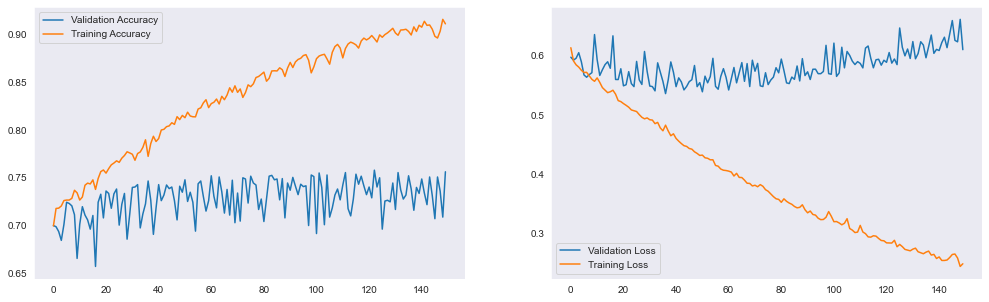

In [30]:
visualize_training_results(baseline_history)

In [31]:
baseline_train_results = baseline_model.evaluate(train_x, train_labels)

314/314 [==============================] - 1s 4ms/step - loss: 0.2287 - accuracy: 0.9224


In [32]:
baseline_val_results = baseline_model.evaluate(val_x, val_labels)

75/75 [==============================] - 0s 5ms/step - loss: 0.6103 - accuracy: 0.7562


In [33]:
baseline_test_results = baseline_model.evaluate(test_x, test_labels)

4/4 [==============================] - 0s 4ms/step - loss: 0.4179 - accuracy: 0.8080


              precision    recall  f1-score   support

         0.0       0.81      0.63      0.71        46
         1.0       0.81      0.91      0.86        79

    accuracy                           0.81       125
   macro avg       0.81      0.77      0.78       125
weighted avg       0.81      0.81      0.80       125



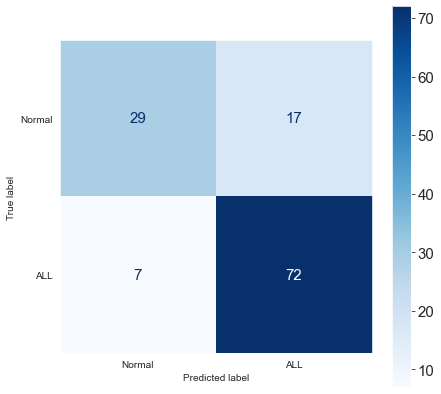

In [34]:
plot_confusion_matrix(baseline_model, test_labels, test_x)

### This model is over-fitting on the training data.        
> #### Our validation scores are not improving and there is no convergence.
> #### However, our test accuracy is not bad for a baseline at 81%

### **Recall is not good enough... 91%**         
> ### **We need to minimize false negatives and maximize correct positive diagnoses**

## Build a baseline Convolutional Neural Network

In [12]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        'data/tvt/train',
        classes={'Normal':0, 'ALL':1},
        class_mode='binary',
        batch_size=10024)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        'data/tvt/validation',
        classes={'Normal':0, 'ALL':1},
        class_mode='binary',
        batch_size = 2379)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        'data/tvt/test',
        classes={'Normal':0, 'ALL':1},        
        class_mode='binary',
        batch_size = 125)


train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)


class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes
                                                 )

train_class_weights = dict(enumerate(class_weights))

Found 10024 images belonging to 2 classes.
Found 2379 images belonging to 2 classes.
Found 125 images belonging to 2 classes.


In [13]:
# Instantiate the model and build it's layers
cnn1 = models.Sequential()

cnn1.add(layers.Conv2D(32,(3,3), activation='relu', padding='same', input_shape=(256,256,3)))
cnn1.add(layers.MaxPool2D(2,2))

cnn1.add(layers.Conv2D(64,(3,3), activation='relu', padding='same'))
cnn1.add(layers.MaxPool2D(2,2))

cnn1.add(layers.Flatten())
cnn1.add(layers.Dense(64, activation='relu'))
cnn1.add(layers.Dense(1, activation='sigmoid'))

In [15]:
# Compile the model
cnn1.compile(optimizer=RMSprop(learning_rate=0.0001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Fit and Train the model
cnn1_history = cnn1.fit(train_images, train_labels,
                        epochs=30,
                        batch_size=100,
                        validation_data=(val_images, val_labels),
                        class_weight=train_class_weights)

Epoch 1/30
101/101 [==============================] - 196s 2s/step - loss: 0.6063 - accuracy: 0.7016 - val_loss: 0.5741 - val_accuracy: 0.7150
Epoch 2/30
101/101 [==============================] - 194s 2s/step - loss: 0.5808 - accuracy: 0.7207 - val_loss: 0.5689 - val_accuracy: 0.7209
Epoch 3/30
101/101 [==============================] - 193s 2s/step - loss: 0.5655 - accuracy: 0.7276 - val_loss: 0.5432 - val_accuracy: 0.7322
Epoch 4/30
101/101 [==============================] - 189s 2s/step - loss: 0.5517 - accuracy: 0.7341 - val_loss: 0.5384 - val_accuracy: 0.7461
Epoch 5/30
101/101 [==============================] - 191s 2s/step - loss: 0.5380 - accuracy: 0.7394 - val_loss: 0.5288 - val_accuracy: 0.7419
Epoch 6/30
101/101 [==============================] - 192s 2s/step - loss: 0.5319 - accuracy: 0.7461 - val_loss: 0.5394 - val_accuracy: 0.7385
Epoch 7/30
101/101 [==============================] - 190s 2s/step - loss: 0.5217 - accuracy: 0.7522 - val_loss: 0.5240 - val_accuracy: 0.7491

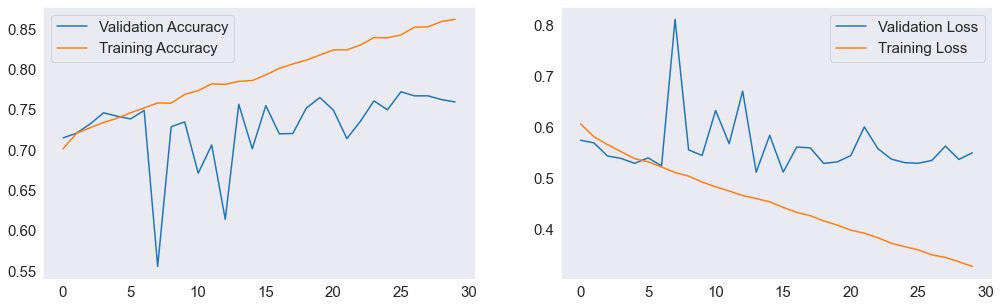

In [22]:
visualize_training_results(cnn1_history)

In [18]:
cnn1_train_results = cnn1.evaluate(train_images, train_labels)

314/314 [==============================] - 51s 162ms/step - loss: 0.2997 - accuracy: 0.8655


In [19]:
cnn1_val_results = cnn1.evaluate(val_images, val_labels)

75/75 [==============================] - 12s 165ms/step - loss: 0.5494 - accuracy: 0.7596


In [20]:
cnn1_test_results = cnn1.evaluate(test_images, test_labels)

4/4 [==============================] - 1s 180ms/step - loss: 0.4352 - accuracy: 0.7760


              precision    recall  f1-score   support

         0.0       0.76      0.57      0.65        46
         1.0       0.78      0.90      0.84        79

    accuracy                           0.78       125
   macro avg       0.77      0.73      0.74       125
weighted avg       0.77      0.78      0.77       125



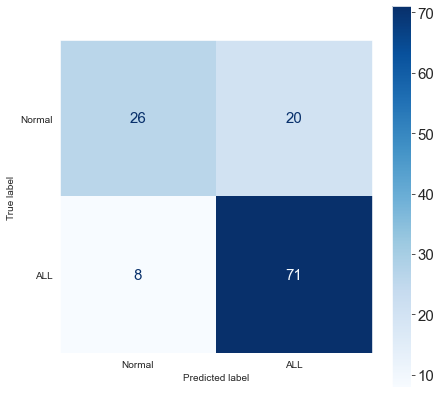

In [21]:
plot_confusion_matrix(cnn1, test_labels, test_images)

### This is worse than our baseline model using only dense layers, but at least we are not over fitting

### It also looks like we need more epochs as our accuracy kept improving and never tailed off

## Now we will build CNNs with more epochs and data augmentation which will hopefully provide a more robust model that will perform better on validation and test data

In [36]:
# Introduce data augmentation methods in our training data generator

train_generator = ImageDataGenerator(rescale=1./255, 
        rotation_range=180, fill_mode='nearest',
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,1.5]).flow_from_directory('data/tvt/train',
                                                        classes={'Normal':0, 'ALL':1},
                                                        class_mode='binary',
                                                        batch_size=10024)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                    'data/tvt/validation',
                                    classes={'Normal':0, 'ALL':1},
                                    class_mode='binary',
                                    batch_size = 2379)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                    'data/tvt/test',
                                    classes={'Normal':0, 'ALL':1},        
                                    class_mode='binary',
                                    batch_size = 125)


train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)


class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes
                                                 )

train_class_weights = dict(enumerate(class_weights))

Found 10024 images belonging to 2 classes.
Found 2379 images belonging to 2 classes.
Found 125 images belonging to 2 classes.


In [37]:
# Instantiate the model and build it's layers
# We will add another CNN layer on this model

cnn_aug = models.Sequential()

cnn_aug.add(layers.Conv2D(32,(3,3), activation='relu', padding='same', input_shape=(256,256,3)))
cnn_aug.add(layers.MaxPool2D(2,2))

cnn_aug.add(layers.Conv2D(64,(3,3), activation='relu', padding='same'))
cnn_aug.add(layers.MaxPool2D(2,2))

cnn_aug.add(layers.Conv2D(64,(3,3), activation='relu', padding='same'))
cnn_aug.add(layers.MaxPool2D(2,2))

cnn_aug.add(layers.Flatten())
cnn_aug.add(layers.Dense(64, activation='relu'))
cnn_aug.add(layers.Dense(1, activation='sigmoid'))

In [38]:
# Compile the model
cnn_aug.compile(optimizer=RMSprop(learning_rate=0.0001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Fit and Train the model with more epochs
cnn_aug_history = cnn_aug.fit(train_images, train_labels,
                        epochs=80,
                        batch_size=100,
                        validation_data=(val_images, val_labels),
                        class_weight=train_class_weights)

Epoch 1/80
101/101 [==============================] - 239s 2s/step - loss: 0.6097 - accuracy: 0.6992 - val_loss: 0.6245 - val_accuracy: 0.6910
Epoch 2/80
101/101 [==============================] - 234s 2s/step - loss: 0.5910 - accuracy: 0.7141 - val_loss: 0.6339 - val_accuracy: 0.6662
Epoch 3/80
101/101 [==============================] - 225s 2s/step - loss: 0.5791 - accuracy: 0.7154 - val_loss: 0.5659 - val_accuracy: 0.7322
Epoch 4/80
101/101 [==============================] - 226s 2s/step - loss: 0.5735 - accuracy: 0.7242 - val_loss: 0.5858 - val_accuracy: 0.7020
Epoch 5/80
101/101 [==============================] - 225s 2s/step - loss: 0.5655 - accuracy: 0.7248 - val_loss: 0.5928 - val_accuracy: 0.7297
Epoch 6/80
101/101 [==============================] - 225s 2s/step - loss: 0.5575 - accuracy: 0.7338 - val_loss: 0.6103 - val_accuracy: 0.7264
Epoch 7/80
101/101 [==============================] - 226s 2s/step - loss: 0.5509 - accuracy: 0.7354 - val_loss: 0.5935 - val_accuracy: 0.6990

Epoch 58/80
101/101 [==============================] - 225s 2s/step - loss: 0.2262 - accuracy: 0.9083 - val_loss: 0.7260 - val_accuracy: 0.6440
Epoch 59/80
101/101 [==============================] - 225s 2s/step - loss: 0.2233 - accuracy: 0.9084 - val_loss: 0.7522 - val_accuracy: 0.6293
Epoch 60/80
101/101 [==============================] - 226s 2s/step - loss: 0.2103 - accuracy: 0.9186 - val_loss: 0.6651 - val_accuracy: 0.6730
Epoch 61/80
101/101 [==============================] - 225s 2s/step - loss: 0.2113 - accuracy: 0.9163 - val_loss: 0.5938 - val_accuracy: 0.7356
Epoch 62/80
101/101 [==============================] - 226s 2s/step - loss: 0.2061 - accuracy: 0.9197 - val_loss: 0.6169 - val_accuracy: 0.7293
Epoch 63/80
101/101 [==============================] - 226s 2s/step - loss: 0.2030 - accuracy: 0.9200 - val_loss: 0.6998 - val_accuracy: 0.6789
Epoch 64/80
101/101 [==============================] - 226s 2s/step - loss: 0.1939 - accuracy: 0.9268 - val_loss: 0.7034 - val_accuracy:

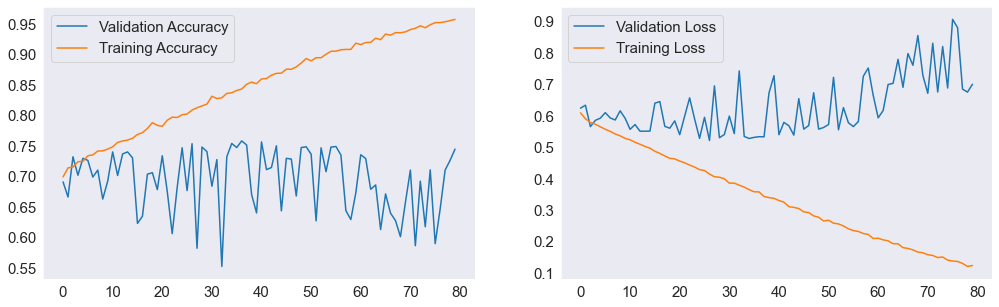

In [39]:
visualize_training_results(cnn_aug_history)

In [40]:
cnn_aug_train_results = cnn_aug.evaluate(train_images, train_labels)

314/314 [==============================] - 63s 200ms/step - loss: 0.1219 - accuracy: 0.9472


In [41]:
cnn_aug_val_results = cnn_aug.evaluate(val_images, val_labels)

75/75 [==============================] - 15s 199ms/step - loss: 0.7005 - accuracy: 0.7449


In [42]:
cnn_aug_test_results = cnn_aug.evaluate(test_images, test_labels)

4/4 [==============================] - 1s 200ms/step - loss: 0.5369 - accuracy: 0.8240


              precision    recall  f1-score   support

         0.0       0.82      0.67      0.74        46
         1.0       0.83      0.91      0.87        79

    accuracy                           0.82       125
   macro avg       0.82      0.79      0.80       125
weighted avg       0.82      0.82      0.82       125



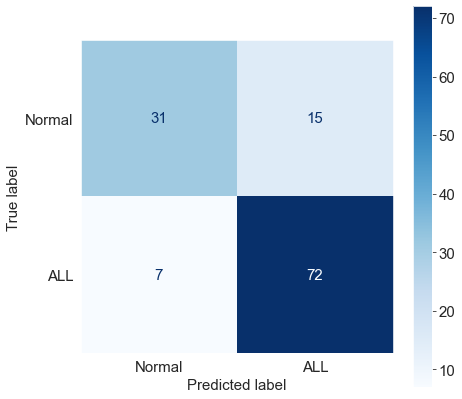

In [43]:
plot_confusion_matrix(cnn_aug, test_labels, test_images)

## Build a CNN with some dropout layers to fight the over fitting

In [44]:
# Instantiate the model and build it's layers
# We will first dropout on the dense layer at the end

cnn_dropout = models.Sequential()

cnn_dropout.add(layers.Conv2D(32,(3,3), activation='relu', padding='same', input_shape=(256,256,3)))
cnn_dropout.add(layers.MaxPool2D(2,2))

cnn_dropout.add(layers.Conv2D(64,(3,3), activation='relu', padding='same'))
cnn_dropout.add(layers.MaxPool2D(2,2))

cnn_dropout.add(layers.Conv2D(64,(3,3), activation='relu', padding='same'))
cnn_dropout.add(layers.MaxPool2D(2,2))

cnn_dropout.add(layers.Flatten())
cnn_dropout.add(layers.Dense(64, activation='relu'))
cnn_dropout.add(layers.Dropout(0.5))
cnn_dropout.add(layers.Dense(1, activation='sigmoid'))

In [45]:
# Compile the model
cnn_dropout.compile(optimizer=RMSprop(learning_rate=0.0001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Fit and Train the model
cnn_dropout_history = cnn_dropout.fit(train_images, train_labels,
                        epochs=80,
                        batch_size=100,
                        validation_data=(val_images, val_labels),
                        class_weight=train_class_weights)

Epoch 1/80
101/101 [==============================] - 225s 2s/step - loss: 0.6123 - accuracy: 0.7027 - val_loss: 0.6028 - val_accuracy: 0.7133
Epoch 2/80
101/101 [==============================] - 225s 2s/step - loss: 0.5974 - accuracy: 0.7083 - val_loss: 0.6007 - val_accuracy: 0.7243
Epoch 3/80
101/101 [==============================] - 224s 2s/step - loss: 0.5904 - accuracy: 0.7149 - val_loss: 0.6277 - val_accuracy: 0.6747
Epoch 4/80
101/101 [==============================] - 224s 2s/step - loss: 0.5850 - accuracy: 0.7173 - val_loss: 0.5855 - val_accuracy: 0.7297
Epoch 5/80
101/101 [==============================] - 224s 2s/step - loss: 0.5785 - accuracy: 0.7286 - val_loss: 0.6089 - val_accuracy: 0.6847
Epoch 6/80
101/101 [==============================] - 225s 2s/step - loss: 0.5713 - accuracy: 0.7265 - val_loss: 0.6732 - val_accuracy: 0.5910
Epoch 7/80
101/101 [==============================] - 224s 2s/step - loss: 0.5688 - accuracy: 0.7305 - val_loss: 0.6213 - val_accuracy: 0.6658

Epoch 58/80
101/101 [==============================] - 224s 2s/step - loss: 0.3386 - accuracy: 0.8580 - val_loss: 0.6004 - val_accuracy: 0.6873
Epoch 59/80
101/101 [==============================] - 224s 2s/step - loss: 0.3360 - accuracy: 0.8565 - val_loss: 0.5564 - val_accuracy: 0.7217
Epoch 60/80
101/101 [==============================] - 224s 2s/step - loss: 0.3240 - accuracy: 0.8615 - val_loss: 0.6450 - val_accuracy: 0.6797
Epoch 61/80
101/101 [==============================] - 225s 2s/step - loss: 0.3237 - accuracy: 0.8596 - val_loss: 0.6167 - val_accuracy: 0.6818
Epoch 62/80
101/101 [==============================] - 225s 2s/step - loss: 0.3217 - accuracy: 0.8631 - val_loss: 0.5947 - val_accuracy: 0.6990
Epoch 63/80
101/101 [==============================] - 225s 2s/step - loss: 0.3106 - accuracy: 0.8661 - val_loss: 0.6250 - val_accuracy: 0.6389
Epoch 64/80
101/101 [==============================] - 225s 2s/step - loss: 0.3120 - accuracy: 0.8680 - val_loss: 0.5658 - val_accuracy:

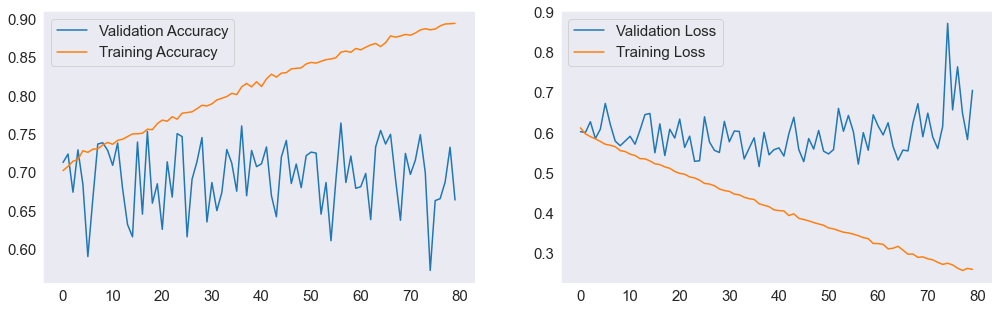

In [46]:
visualize_training_results(cnn_dropout_history)

In [47]:
cnn_dropout_train_results = cnn_dropout.evaluate(train_images, train_labels)

314/314 [==============================] - 63s 199ms/step - loss: 0.2219 - accuracy: 0.9148


In [48]:
cnn_dropout_val_results = cnn_dropout.evaluate(val_images, val_labels)

75/75 [==============================] - 15s 197ms/step - loss: 0.7059 - accuracy: 0.6646


In [49]:
cnn_dropout_test_results = cnn_dropout.evaluate(test_images, test_labels)

4/4 [==============================] - 1s 195ms/step - loss: 0.4223 - accuracy: 0.8160


              precision    recall  f1-score   support

         0.0       0.70      0.87      0.78        46
         1.0       0.91      0.78      0.84        79

    accuracy                           0.82       125
   macro avg       0.81      0.83      0.81       125
weighted avg       0.83      0.82      0.82       125



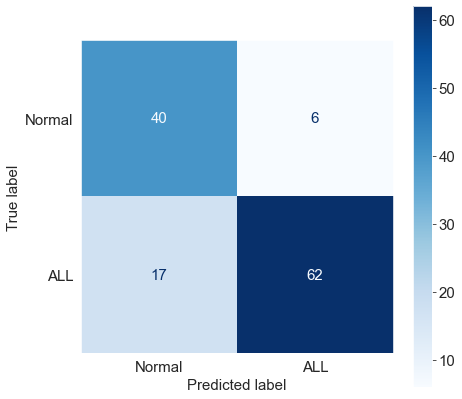

In [50]:
plot_confusion_matrix(cnn_dropout, test_labels, test_images)

## Add more dropout layers

In [51]:
cnn_dropout_2 = models.Sequential()

cnn_dropout_2.add(layers.Conv2D(32,(3,3), activation='relu', padding='same', input_shape=(256,256,3)))
cnn_dropout_2.add(layers.MaxPool2D(2,2))

cnn_dropout_2.add(layers.Conv2D(64,(3,3), activation='relu', padding='same'))
cnn_dropout_2.add(layers.MaxPool2D(2,2))

cnn_dropout_2.add(layers.Conv2D(128,(3,3), activation='relu', padding='same'))
cnn_dropout_2.add(layers.MaxPool2D(2,2))
cnn_dropout_2.add(layers.Dropout(0.5))

cnn_dropout_2.add(layers.Flatten())
cnn_dropout_2.add(layers.Dense(64, activation='relu'))
cnn_dropout_2.add(layers.Dropout(0.5))
cnn_dropout_2.add(layers.Dense(1, activation='sigmoid'))

In [52]:
# Compile the model
cnn_dropout_2.compile(optimizer=RMSprop(learning_rate=0.00001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Fit and Train the model
cnn_dropout_2_history = cnn_dropout_2.fit(train_images, train_labels,
                        epochs=80,
                        batch_size=100,
                        validation_data=(val_images, val_labels),
                        class_weight=train_class_weights)

Epoch 1/80
101/101 [==============================] - 253s 3s/step - loss: 0.6377 - accuracy: 0.6966 - val_loss: 0.6273 - val_accuracy: 0.6974
Epoch 2/80
101/101 [==============================] - 252s 3s/step - loss: 0.6112 - accuracy: 0.6948 - val_loss: 0.6265 - val_accuracy: 0.6944
Epoch 3/80
101/101 [==============================] - 253s 3s/step - loss: 0.6033 - accuracy: 0.7009 - val_loss: 0.6345 - val_accuracy: 0.6953
Epoch 4/80
101/101 [==============================] - 253s 3s/step - loss: 0.5985 - accuracy: 0.7067 - val_loss: 0.6114 - val_accuracy: 0.7058
Epoch 5/80
101/101 [==============================] - 253s 3s/step - loss: 0.5958 - accuracy: 0.7159 - val_loss: 0.6273 - val_accuracy: 0.6999
Epoch 6/80
101/101 [==============================] - 255s 3s/step - loss: 0.5922 - accuracy: 0.7192 - val_loss: 0.6169 - val_accuracy: 0.7032
Epoch 7/80
101/101 [==============================] - 254s 3s/step - loss: 0.5886 - accuracy: 0.7189 - val_loss: 0.6149 - val_accuracy: 0.7016

Epoch 58/80
101/101 [==============================] - 260s 3s/step - loss: 0.5192 - accuracy: 0.7526 - val_loss: 0.6948 - val_accuracy: 0.5990
Epoch 59/80
101/101 [==============================] - 260s 3s/step - loss: 0.5212 - accuracy: 0.7558 - val_loss: 0.5936 - val_accuracy: 0.6856
Epoch 60/80
101/101 [==============================] - 260s 3s/step - loss: 0.5193 - accuracy: 0.7571 - val_loss: 0.6401 - val_accuracy: 0.6452
Epoch 61/80
101/101 [==============================] - 260s 3s/step - loss: 0.5183 - accuracy: 0.7598 - val_loss: 0.6936 - val_accuracy: 0.6019
Epoch 62/80
101/101 [==============================] - 266s 3s/step - loss: 0.5165 - accuracy: 0.7588 - val_loss: 0.6121 - val_accuracy: 0.6709
Epoch 63/80
101/101 [==============================] - 277s 3s/step - loss: 0.5180 - accuracy: 0.7552 - val_loss: 0.6504 - val_accuracy: 0.6377
Epoch 64/80
101/101 [==============================] - 273s 3s/step - loss: 0.5138 - accuracy: 0.7614 - val_loss: 0.6745 - val_accuracy:

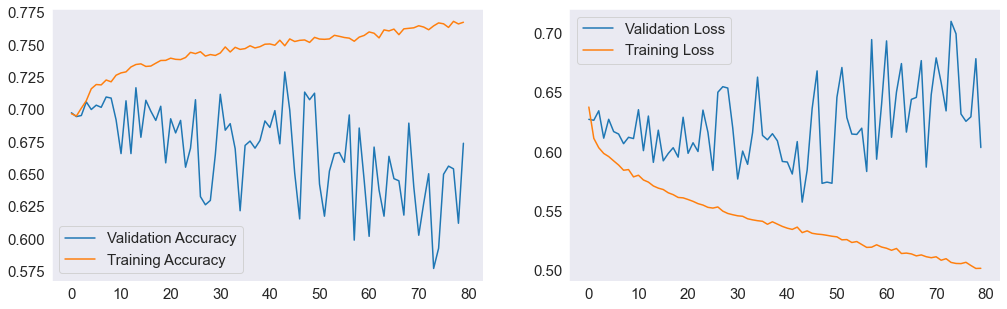

In [53]:
visualize_training_results(cnn_dropout_2_history)

In [54]:
cnn_dropout_2_train_results = cnn_dropout_2.evaluate(train_images, train_labels)

314/314 [==============================] - 75s 237ms/step - loss: 0.4731 - accuracy: 0.7850


In [55]:
cnn_dropout_2_val_results = cnn_dropout_2.evaluate(val_images, val_labels)

75/75 [==============================] - 19s 257ms/step - loss: 0.6034 - accuracy: 0.6738


In [56]:
cnn_dropout_2_test_results = cnn_dropout_2.evaluate(test_images, test_labels)

4/4 [==============================] - 1s 245ms/step - loss: 0.4951 - accuracy: 0.7920


              precision    recall  f1-score   support

         0.0       0.67      0.85      0.75        46
         1.0       0.90      0.76      0.82        79

    accuracy                           0.79       125
   macro avg       0.78      0.80      0.79       125
weighted avg       0.81      0.79      0.80       125



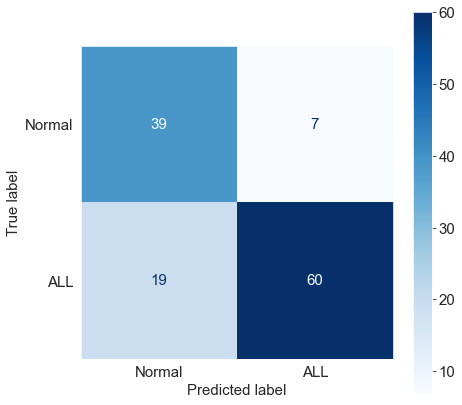

In [57]:
plot_confusion_matrix(cnn_dropout_2, test_labels, test_images)

In [58]:
cnn_reg = models.Sequential()

cnn_reg.add(layers.Conv2D(32,(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.005),
                                padding='same', input_shape=(256,256,3)))
cnn_reg.add(layers.MaxPool2D(2,2))

cnn_reg.add(layers.Conv2D(64,(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.005),
                                padding='same'))
cnn_reg.add(layers.MaxPool2D(2,2))
cnn_reg.add(layers.Dropout(0.25))

cnn_reg.add(layers.Conv2D(128,(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.005),
                                padding='same'))
cnn_reg.add(layers.MaxPool2D(2,2))
cnn_reg.add(layers.Dropout(0.25))

cnn_reg.add(layers.Flatten())
cnn_reg.add(layers.Dense(64, activation='relu'))
cnn_reg.add(layers.Dropout(0.25))
cnn_reg.add(layers.Dense(128, activation='relu'))
cnn_reg.add(layers.Dropout(0.25))
cnn_reg.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
cnn_reg.compile(optimizer=RMSprop(learning_rate=0.0001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Fit and Train the model
cnn_reg_history = cnn_reg.fit(train_images, train_labels,
                        epochs=100,
                        batch_size=100,
                        validation_data=(val_images, val_labels),
                        class_weight=train_class_weights)

Epoch 1/100
101/101 [==============================] - 274s 3s/step - loss: 1.1674 - accuracy: 0.6715 - val_loss: 1.0847 - val_accuracy: 0.7137
Epoch 2/100
101/101 [==============================] - 272s 3s/step - loss: 0.9814 - accuracy: 0.6980 - val_loss: 0.9340 - val_accuracy: 0.7247
Epoch 3/100
101/101 [==============================] - 273s 3s/step - loss: 0.8573 - accuracy: 0.7030 - val_loss: 0.8249 - val_accuracy: 0.7217
Epoch 4/100
101/101 [==============================] - 276s 3s/step - loss: 0.7765 - accuracy: 0.7069 - val_loss: 0.7536 - val_accuracy: 0.7255
Epoch 5/100
101/101 [==============================] - 273s 3s/step - loss: 0.7211 - accuracy: 0.7091 - val_loss: 0.7031 - val_accuracy: 0.7217
Epoch 6/100
101/101 [==============================] - 271s 3s/step - loss: 0.6884 - accuracy: 0.7152 - val_loss: 0.6843 - val_accuracy: 0.7167
Epoch 7/100
101/101 [==============================] - 274s 3s/step - loss: 0.6648 - accuracy: 0.7099 - val_loss: 0.6733 - val_accuracy:

In [ ]:
visualize_training_results(cnn_reg_history)

In [ ]:
cnn_reg_train_results = cnn_reg.evaluate(train_images, train_labels)

In [ ]:
cnn_reg_val_results = cnn_reg.evaluate(val_images, val_labels)

In [ ]:
cnn_reg_test_results = cnn_reg.evaluate(test_images, test_labels)

In [ ]:
plot_confusion_matrix(cnn_reg, test_labels, test_images)